# 第7回 識別その3: 続・様々な識別手法の紹介_old

いつものように右上の「Remix」ボタンを押して自分用の複製を作成すれば、各セルを「Shift+Enter」で実行しながら読むことができます

編集を行なった後は、Windowsは「Ctrl+s」、Macは「Cmd+s」で保存することができます

必要なパッケージを読み込みます。今回は決定木のパッケージであるDecisionTreeとXGBoostを使うので、まずそれをインストールします

In [1]:
]add DecisionTree

In [1]:
]add XGBoost

In [1]:
using Plots, Statistics, CSV, DecisionTree

# フィッシャーのあやめの読み込み

今回は最初からフィッシャーのあやめを題材に使います。

アヤメの個体150サンプルについて、以下の4つの特徴量を計測して、その種(3種, setosa, versicolor, virginica)がラベル付けされています。

1. SepalLength ガクの長さ (cm単位、説明変数)
2. SepalWidth ガクの太さ (cm単位、説明変数)
3. PetalLength 花弁の長さ (cm単位、説明変数)
4. PetalWidth 花弁の太さ (cm単位、説明変数)
5. Species 種類 (setosa, versicolor, virginica、ラベル・目的変数)

[iris.csv](https://nextjournal.com/data/QmP6fvLv5D5ozPEcbK1vxmbBua2cVZGs7paMudgjhJox5U?content-type=text/csv&node-id=dd37696c-2e66-4a92-ac5c-11c1443b4030&filename=iris.csv&node-kind=file)

![iris.png](https://nextjournal.com/data/QmcsTUT7gawLt7FGkvJhLYSug8S6Zi8t4DcfkchqF3dzR9?content-type=image/png&node-id=a4e7eb42-a204-410d-b0b2-e0c7bee2c663&filename=iris.png&node-kind=file)


In [1]:
# CSVデータの読み込み
iris = CSV.read("/.nextjournal/data-named/QmP6fvLv5D5ozPEcbK1vxmbBua2cVZGs7paMudgjhJox5U/iris.csv")

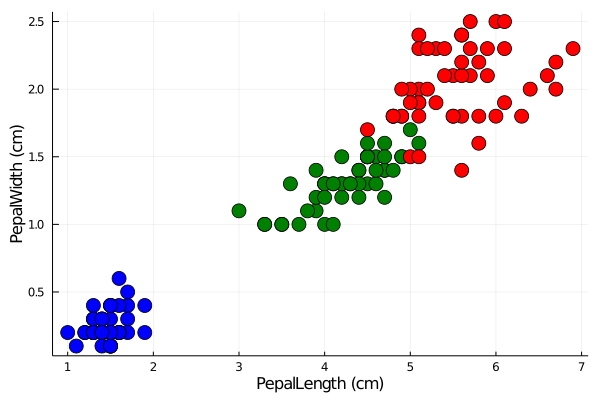

In [1]:
N = size(iris, 1)

y = Array{String}(undef, N)
yreal = Array{Float64}(undef, N)
c = fill(:blue, N)
for n = 1:N
  y[n] = iris.Species[n]
  if y[n] == "setosa"
    yreal[n] = 0.0
    c[n] = :blue
  elseif y[n] == "versicolor"
    yreal[n] = 1.0
    c[n] = :green
  else #verginica
    yreal[n] = 2.0
    c[n] = :red
  end
end

x = Array(iris[:, 2:5])

scatter(x[:, 3], x[:, 4], xlabel="PepalLength (cm)", ylabel="PepalWidth (cm)", markersize=8, markercolor=c, legend=:false)

訓練用データとテスト用データに分けておきます

In [1]:
y_train = y[1:2:end]
yreal_train = yreal[1:2:end]
x_train = x[1:2:end, :]
y_test = y[2:2:end]
yreal_test = yreal[2:2:end]
x_test = x[2:2:end, :]

75×4 Array{Float64,2}:
 4.9  3.0  1.4  0.2
 4.6  3.1  1.5  0.2
 5.4  3.9  1.7  0.4
 5.0  3.4  1.5  0.2
 4.9  3.1  1.5  0.1
 4.8  3.4  1.6  0.2
 4.3  3.0  1.1  0.1
 5.7  4.4  1.5  0.4
 5.1  3.5  1.4  0.3
 5.1  3.8  1.5  0.3
 ⋮              
 6.3  2.8  5.1  1.5
 7.7  3.0  6.1  2.3
 6.4  3.1  5.5  1.8
 6.9  3.1  5.4  2.1
 6.9  3.1  5.1  2.3
 6.8  3.2  5.9  2.3
 6.7  3.0  5.2  2.3
 6.5  3.0  5.2  2.0
 5.9  3.0  5.1  1.8

# 決定木

In [1]:
# パラメータの一覧と説明
# set of classification parameters and respective default values
# pruning_purity: purity threshold used for post-pruning (default: 1.0, no pruning)
# max_depth: maximum depth of the decision tree (default: -1, no maximum)
# min_samples_leaf: the minimum number of samples each leaf needs to have (default: 1)
# min_samples_split: the minimum number of samples in needed for a split (default: 2)
# min_purity_increase: minimum purity needed for a split (default: 0.0)
# n_subfeatures: number of features to select at random (default: 0, keep all)

# train decision tree classifier
model = DecisionTreeClassifier(max_depth=2)
fit!(model, x_train, y_train)

DecisionTreeClassifier
max_depth:                2
min_samples_leaf:         1
min_samples_split:        2
min_purity_increase:      0.0
pruning_purity_threshold: 1.0
n_subfeatures:            0
classes:                  ["setosa", "versicolor", "virginica"]
root:                     Decision Tree
Leaves: 3
Depth:  2

In [1]:
print_tree(model, 5)

In [1]:
predict(model, [5.9, 3.0, 5.1, 1.9])

"virginica"

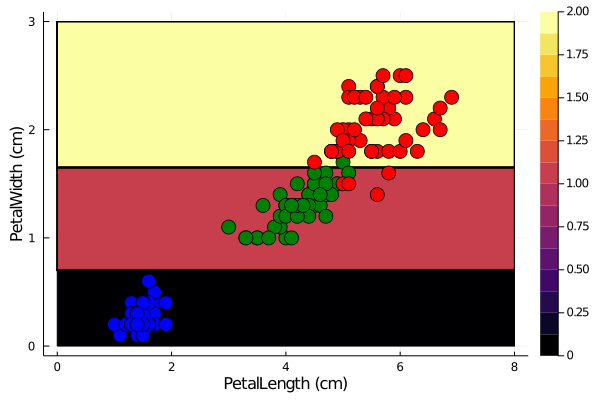

In [1]:
function f(x3, x4)
  y = predict(model, [mean(x_train[:, 1]), mean(x_train[:, 2]), x3, x4])
  if y == "setosa"
    return 0
  elseif y == "versicolor"
    return 1
  else
    return 2
  end
end

x3 = range(0.0, 8.0, length = 200)
x4 = range(0.0, 3.0, length = 200)
contourf(x3, x4, f)

scatter!(x[:, 3], x[:, 4], xlabel="PetalLength (cm)", ylabel="PetalWidth (cm)", markersize=8, markercolor=c, legend=false)

テスト用データを使って汎化性能を評価します

In [1]:
predicted_labels = predict(model, x_test);
println("Accuracy is ", mean((predicted_labels .== y_test))*100)

# ランダムフォレスト

アンサンブル学習の代表手法であるランダムフォレストを使ってみましょう

In [1]:
# パラメータの一覧と説明
# set of classification parameters and respective default values
# n_subfeatures: number of features to consider at random per split (default: -1, sqrt(# features))
# n_trees: number of trees to train (default: 10)
# partial_sampling: fraction of samples to train each tree on (default: 0.7)
# max_depth: maximum depth of the decision trees (default: no maximum)
# min_samples_leaf: the minimum number of samples each leaf needs to have (default: 5)
# min_samples_split: the minimum number of samples in needed for a split (default: 2)
# min_purity_increase: minimum purity needed for a split (default: 0.0)

# train random forest classifier
model = RandomForestClassifier(max_depth=2, n_trees=75)
fit!(model, x_train, y_train)

RandomForestClassifier
n_trees:             75
n_subfeatures:       -1
partial_sampling:    0.7
max_depth:           2
min_samples_leaf:    1
min_samples_split:   2
min_purity_increase: 0.0
classes:             ["setosa", "versicolor", "virginica"]
ensemble:            Ensemble of Decision Trees
Trees:      75
Avg Leaves: 3.1466666666666665
Avg Depth:  2.0

In [1]:
# apply learned model
predict(model, [5.9, 3.0, 5.1, 1.9])

"virginica"

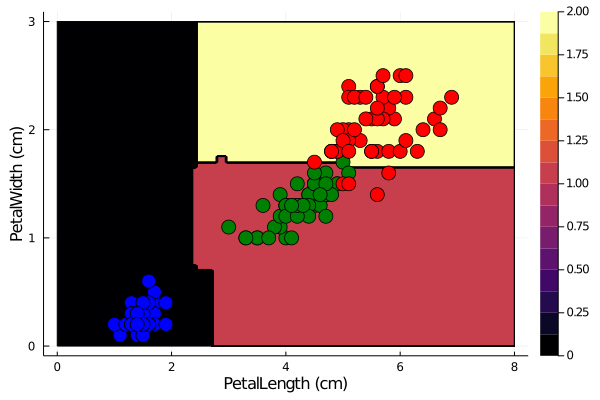

In [1]:
x3 = range(0.0, 8.0, length = 200)
x4 = range(0.0, 3.0, length = 200)
contourf(x3, x4, f)

scatter!(x[:, 3], x[:, 4], xlabel="PetalLength (cm)", ylabel="PetalWidth (cm)", markersize=8, markercolor=c, legend=false)

テスト用データを使って汎化性能を評価します

In [1]:
predicted_labels = predict(model, x_test);
println("Accuracy is ", mean((predicted_labels .== y_test))*100)

# ブースティング

ブースティングの拡張手法の一つであるXGBoostを使ってみましょう

パラメータの一覧は以下を参考にしてください

 <https://qiita.com/aaatsushi_bb/items/0b605c0f27493f005c88>

In [1]:
using XGBoost

In [1]:
num_round = 2
bst = XGBoost.xgboost(x_train, num_round, label=yreal_train, eta=1, max_depth=2)

Booster(Ptr{Nothing} @0x0000000003a119d0)

In [1]:
pred = XGBoost.predict(bst, x_test)

75-element Array{Float32,1}:
 0.0026395
 0.0026395
 0.0026395
 0.0026395
 0.0026395
 0.0026395
 0.0026395
 0.0026395
 0.0026395
 0.0026395
 ⋮
 1.50962
 1.99563
 1.99563
 1.99563
 1.99563
 1.99563
 1.99563
 1.99563
 1.99563

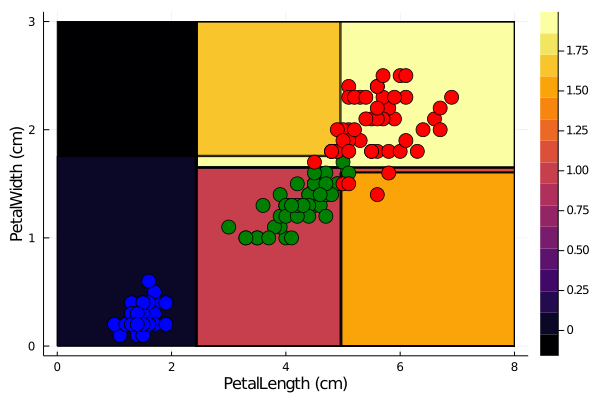

In [1]:
f(x3, x4) = XGBoost.predict(bst, [mean(x_train[:, 1]) mean(x_train[:, 2]) x3 x4])[1]

x3 = range(0.0, 8.0, length = 200)
x4 = range(0.0, 3.0, length = 200)
contourf(x3, x4, f)

scatter!(x[:, 3], x[:, 4], xlabel="PetalLength (cm)", ylabel="PetalWidth (cm)", markersize=8, markercolor=c, legend=false)

In [1]:
pred = XGBoost.predict(bst, x_test)
println("Accuracy is ", mean((Int.(round.(pred)) .== Int.(yreal_test))*100))

# やってみよう：MNISTの識別

XGBoostを使ってMNISTの手書き数字データを識別させてみましょう。非常に雑な使い方をしているので性能が出ていませんが。取りあえず動くことを確認したり、前処理の導入や、パラメータの調整をして改造してみましょう。パラメータの調整は以下を参考にしてください

 <https://qiita.com/aaatsushi_bb/items/0b605c0f27493f005c88>

MNISTデータは機械学習の画像認識の分野で有名なデータです。0から9までの数字を手書きした画像データ 60,000枚に対してその答えである数字がラベルされています。

* 1列目 数字の答え (ラベル、目的変数)
* 2列目〜785列目 28×28ピクセルの白黒画像の濃淡 (説明変数)

データ容量の制限から、ここでは画像データ60,000枚を5,000枚に削減したものを置いておきます。

[mnist_reduced.csv](https://nextjournal.com/data/QmUsVajJ792FPfc9AEqm3C2EdemFfCUTERQpEgModigvjW?content-type=text/csv&node-id=b2de440c-98a1-47cf-a464-eb96d862f36e&filename=mnist_reduced.csv&node-kind=file)


In [1]:
# CSVデータの読み込み、labelは正解の数字を示す。その他のカラムは画像の各ピクセルの濃さ(白黒)に対応する
mnist = CSV.read("/.nextjournal/data-named/QmUsVajJ792FPfc9AEqm3C2EdemFfCUTERQpEgModigvjW/mnist_reduced.csv")

# データが1列目のラベル(数字)以外は画像なので、Array(Matrix)へ変換して扱うことにする
mnist = Float64.(convert(Matrix, mnist))

5000×785 Array{Float64,2}:
 5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 9.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 7.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 8.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

In [1]:
y_train = mnist[1:2500, 1]
x_train = mnist[1:2500, 2:end]
y_test = mnist[2501:end, 1]
x_test = mnist[2501:end, 2:end]

2500×784 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱                 ⋮              
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

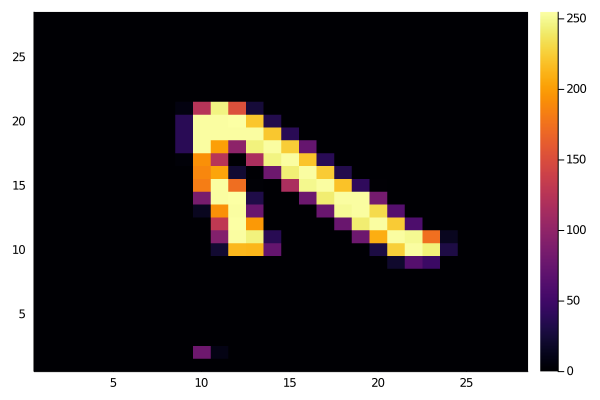

In [1]:
# 試しに30番目のエントリ(30行列目)の画像を表示させてみる
heatmap(reshape(x_train[30, :], 28, 28))

In [1]:
num_round = 2
bst = XGBoost.xgboost(x_train, num_round, label=y_train, eta=1, max_depth=5)

Booster(Ptr{Nothing} @0x0000000008402840)

In [1]:
pred = Int.(round.(XGBoost.predict(bst, x_test)))

2500-element Array{Int64,1}:
  0
  7
  6
  3
  6
  3
  3
  8
  2
  7
  ⋮
  7
  7
  1
 -1
  5
  3
  6
  1
  6

In [1]:
println("Accuracy is ", mean((pred .== y_test))*100)